In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction/test_loan.csv
/kaggle/input/loan-prediction/train_loan.csv


In [2]:
!pip install pyspark==3.2
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col# Initialize Spark session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 10.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805894 sha256=23e94a1f25ab91a3f5eff47111274ebdd41f94081af380e97f1af43f6b331b42
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
import glob

# Initialize Spark Session
spark = SparkSession.builder.appName("LoanPrediction").getOrCreate()

# Define the expected schema with correct column names and data types
schema = StructType([
    StructField("Gender", StringType(), True),
    StructField("Married", StringType(), True),
    StructField("Dependents", StringType(), True),
    StructField("Education", StringType(), True),
    StructField("Self_Employed", StringType(), True),
    StructField("ApplicantIncome", IntegerType(), True),
    StructField("CoapplicantIncome", FloatType(), True),
    StructField("LoanAmount", FloatType(), True),
    StructField("Loan_Amount_Term", FloatType(), True),
    StructField("Credit_History", FloatType(), True),
    StructField("Property_Area", StringType(), True),
    StructField("Loan_Status", StringType(), True)
])

# Define the expected column names as a list
expected_columns = [field.name for field in schema]

# Collect all file paths to load
file_paths = glob.glob("/kaggle/input/loan-prediction/*.csv")

# Placeholder for DataFrames
dfs = []

# Load each file individually without schema enforcement, then align columns
for file_path in file_paths:
    print(f"Loading file: {file_path}")
    
    # Load file without enforcing schema
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    # Check for missing columns and add them with null values if necessary
    for col_name in expected_columns:
        if col_name not in df.columns:
            df = df.withColumn(col_name, F.lit(None))
    
    # Reorder columns to match the expected schema
    df = df.select(expected_columns)
    
    # Append to the list of DataFrames
    dfs.append(df)

# Combine all DataFrames into a single DataFrame by aligning column names
df = dfs[0]
for next_df in dfs[1:]:
    df = df.unionByName(next_df)

# Verify the final schema
print("Final DataFrame Schema:")
df.printSchema()



Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/26 14:12:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Loading file: /kaggle/input/loan-prediction/test_loan.csv
Loading file: /kaggle/input/loan-prediction/train_loan.csv
Final DataFrame Schema:
root
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



In [4]:
# Proceed with data cleaning and preprocessing steps as per assignment requirements

# Drop rows with missing Loan_Status
df = df.dropna(subset=["Loan_Status"])

# Fill missing values in numerical columns
mean_loan_amount = df.agg({"LoanAmount": "mean"}).collect()[0][0]
df = df.fillna({"LoanAmount": mean_loan_amount})

# Fill missing values in categorical columns
df = df.fillna({"Gender": "Unknown", "Married": "No", "Self_Employed": "No"})

# Display the first few rows to verify data integrity
df.show(5)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|  Male|     No|         0|    Graduate|           No|           5849|              0.0|       146|             360|             1|        Urban|          Y|
|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y|
|  Male|    Yes|         0|Not Graduate|           N

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# List of categorical columns to encode
categorical_cols = ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in categorical_cols]

# Label indexer for target variable
label_indexer = StringIndexer(inputCol="Loan_Status", outputCol="label", handleInvalid="keep")

# Ensure numeric columns have no nulls
numeric_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
for col in numeric_cols:
    df = df.fillna({col: 0})  # Fill nulls in numeric columns with 0 or another reasonable default

# Assemble feature columns into a single vector
feature_cols = numeric_cols + [col + "_Vec" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

# Split the dataset into training (70%) and test (30%) sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=1234)

# Initialize the two models
lr = LogisticRegression(featuresCol="features", labelCol="label")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Create pipelines for each model
stages = indexers + encoders + [label_indexer, assembler]
pipeline_lr = Pipeline(stages=stages + [lr])
pipeline_dt = Pipeline(stages=stages + [dt])

# Train each model
lr_model = pipeline_lr.fit(train_df)
dt_model = pipeline_dt.fit(train_df)

# Make predictions on the test set
lr_predictions = lr_model.transform(test_df)
dt_predictions = dt_model.transform(test_df)

# Initialize evaluator for Accuracy, Precision, and Recall
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate Logistic Regression
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})

# Evaluate Decision Tree
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})



In [6]:
# Print results
print("Logistic Regression - Accuracy:", lr_accuracy, "Precision:", lr_precision, "Recall:", lr_recall)
print("Decision Tree - Accuracy:", dt_accuracy, "Precision:", dt_precision, "Recall:", dt_recall)



Logistic Regression - Accuracy: 0.776536312849162 Precision: 0.7689399365377019 Recall: 0.776536312849162
Decision Tree - Accuracy: 0.770949720670391 Precision: 0.7618180774211932 Recall: 0.770949720670391


In [7]:
# Confusion Matrix for Logistic Regression
print("Confusion Matrix - Logistic Regression")
lr_predictions.groupBy("label", "prediction").count().show()



Confusion Matrix - Logistic Regression
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   26|
|  0.0|       1.0|   10|
|  1.0|       0.0|   30|
|  0.0|       0.0|  113|
+-----+----------+-----+



In [8]:
# Confusion Matrix for Decision Tree
print("Confusion Matrix - Decision Tree")
dt_predictions.groupBy("label", "prediction").count().show()

Confusion Matrix - Decision Tree
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   26|
|  0.0|       1.0|   11|
|  1.0|       0.0|   30|
|  0.0|       0.0|  112|
+-----+----------+-----+



In [9]:
# Correctly structure the data for comparison
comparison_data = [
    ("Accuracy", lr_accuracy, dt_accuracy),
    ("Precision", lr_precision, dt_precision),
    ("Recall", lr_recall, dt_recall)
]

# Create Spark DataFrame with the correct structure
comparison_df = spark.createDataFrame(comparison_data, ["Metric", "Logistic Regression", "Decision Tree"])

# Display comparison table
comparison_df.show()

+---------+-------------------+------------------+
|   Metric|Logistic Regression|     Decision Tree|
+---------+-------------------+------------------+
| Accuracy|  0.776536312849162| 0.770949720670391|
|Precision| 0.7689399365377019|0.7618180774211932|
|   Recall|  0.776536312849162| 0.770949720670391|
+---------+-------------------+------------------+



In [10]:
# Confusion Matrix for Logistic Regression
print("Confusion Matrix - Logistic Regression")
lr_predictions.groupBy("label", "prediction").count().show()



Confusion Matrix - Logistic Regression
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   26|
|  0.0|       1.0|   10|
|  1.0|       0.0|   30|
|  0.0|       0.0|  113|
+-----+----------+-----+



In [11]:
# Confusion Matrix for Decision Tree
print("Confusion Matrix - Decision Tree")
dt_predictions.groupBy("label", "prediction").count().show()

Confusion Matrix - Decision Tree
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   26|
|  0.0|       1.0|   11|
|  1.0|       0.0|   30|
|  0.0|       0.0|  112|
+-----+----------+-----+



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import DataFrame

# Function to plot confusion matrix as a heatmap
def plot_confusion_matrix(predictions: DataFrame, model_name: str):
    # Group by label and prediction to create the confusion matrix
    confusion_df = (
        predictions.groupBy("label", "prediction")
        .count()
        .toPandas()
        .pivot(index="label", columns="prediction", values="count")
        .fillna(0)
    )
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_df, annot=True, fmt="g", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()





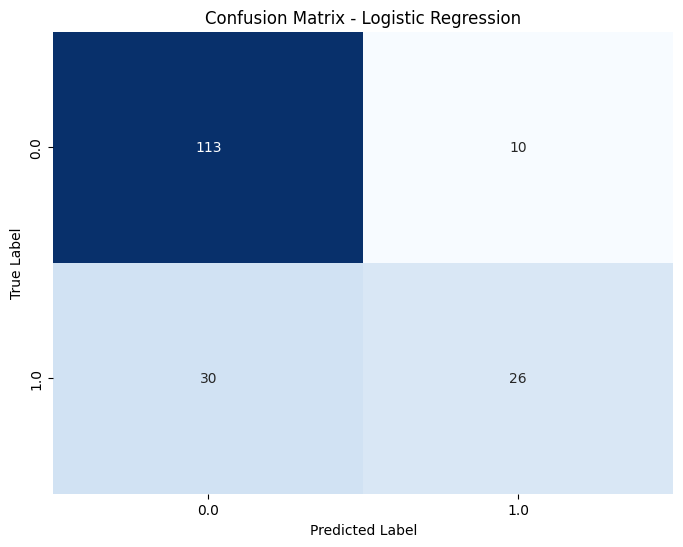

In [13]:
# Logistic Regression Confusion Matrix
plot_confusion_matrix(lr_predictions, "Logistic Regression")

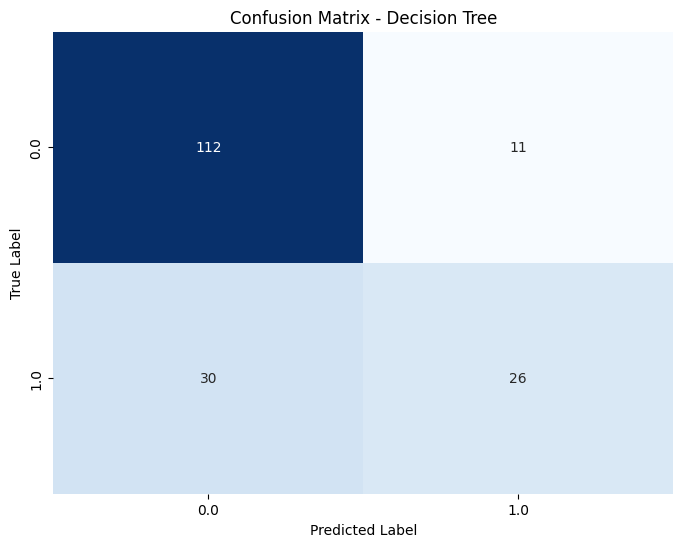

In [14]:
# Decision Tree Confusion Matrix
plot_confusion_matrix(dt_predictions, "Decision Tree")